# Imports

In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from random import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/home/jeris/src/kaggle-competitions/env/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
2021-07-31 16:30:06.312875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-31 16:30:06.312902: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data_path = '~/../../media/sf_data/'
file_name = 'seti_breakthrough_listen_et'
data_path = data_path + file_name

In [3]:
TARGET = 'target'

In [4]:
def get_train_file_path(image_id):
    return f"{data_path}/train/{image_id[0]}/{image_id}.npy"

def get_test_file_path(image_id):
    return f"{data_path}/test/{image_id[0]}/{image_id}.npy"

In [5]:
train = pd.read_csv(data_path + '/train_labels.csv')
train['file_path'] = train['id'].apply(get_train_file_path)
train['file_path'] = train['file_path'].str.split('~/../..').str[-1]

test = pd.read_csv(data_path + '/sample_submission.csv')
test['file_path'] = test['id'].apply(get_test_file_path)
test['file_path'] = test['file_path'].str.split('~/../..').str[-1]

In [6]:
tmp = train.query('target==1')
tmp['folder'] = tmp['id'].str[0]
tmp.groupby('folder')['folder'].count().sort_values(ascending=False)

/home/jeris/src/kaggle-competitions/env/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


folder
f    312
3    310
6    306
c    305
5    302
8    301
0    294
9    293
e    293
7    291
a    286
2    283
4    283
b    281
1    278
d    276
Name: folder, dtype: int64

In [7]:
train.head()

,id,target,file_path
0,00034abb3629,0,/media/sf_data/seti_breakthrough_listen_et/train/0/00034abb3629.npy
1,0004300a0b9b,0,/media/sf_data/seti_breakthrough_listen_et/train/0/0004300a0b9b.npy
2,000453852fda,0,/media/sf_data/seti_breakthrough_listen_et/train/0/000453852fda.npy
3,00047dfc96a9,0,/media/sf_data/seti_breakthrough_listen_et/train/0/00047dfc96a9.npy
4,0004be0baf70,0,/media/sf_data/seti_breakthrough_listen_et/train/0/0004be0baf70.npy


# EDA

<AxesSubplot:>

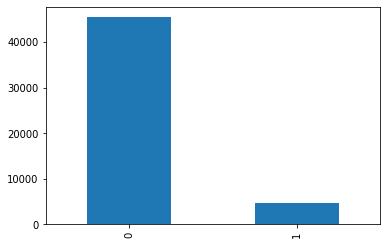

In [8]:
train[TARGET].value_counts().plot(kind='bar')

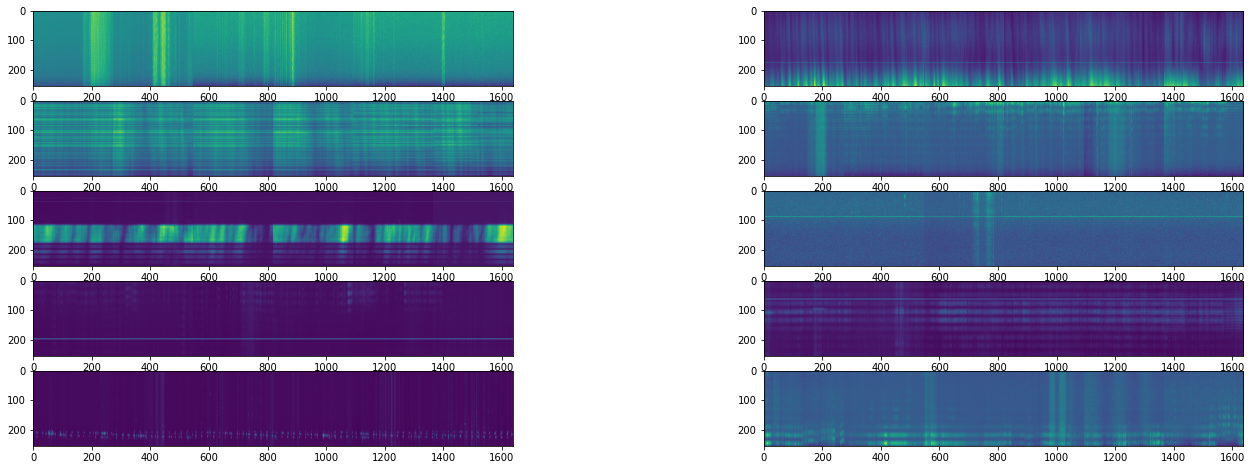

In [9]:
plt.figure(figsize=(24,8))
for i in range(10):
    image = np.load(train.loc[i,'file_path'])
    image = image.astype(np.float32)
    image = np.vstack(image).transpose((1, 0)) # (1638, 256) -> (256, 1638)
    plt.subplot(5, 2, i + 1)
    plt.imshow(image)
plt.show()

## Show Cadence

In [10]:
def show_cadence(filename, label=None):
    plt.figure(figsize=(16, 10))
    arr = np.load(filename)
    for i in range(6):
        plt.subplot(6, 1, i + 1)
        if i == 0:
            if label is not None:
                plt.title(f'ID: {os.path.basename(filename)} TARGET: {label}', fontsize=18)
        plt.imshow(arr[i].astype(float), interpolation='nearest', aspect='auto')
        plt.text(5, 100, ['ON', 'OFF'][i % 2], bbox={'facecolor': 'white'})
        plt.xticks([])
    plt.show()

In [11]:
pos_train = train.query('target == 1')
neg_train = train.query('target != 1')

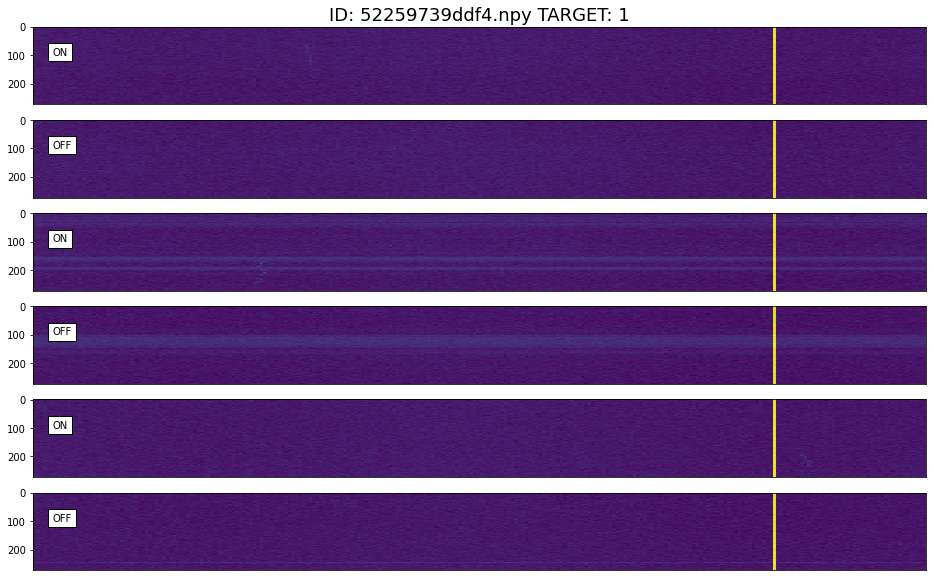

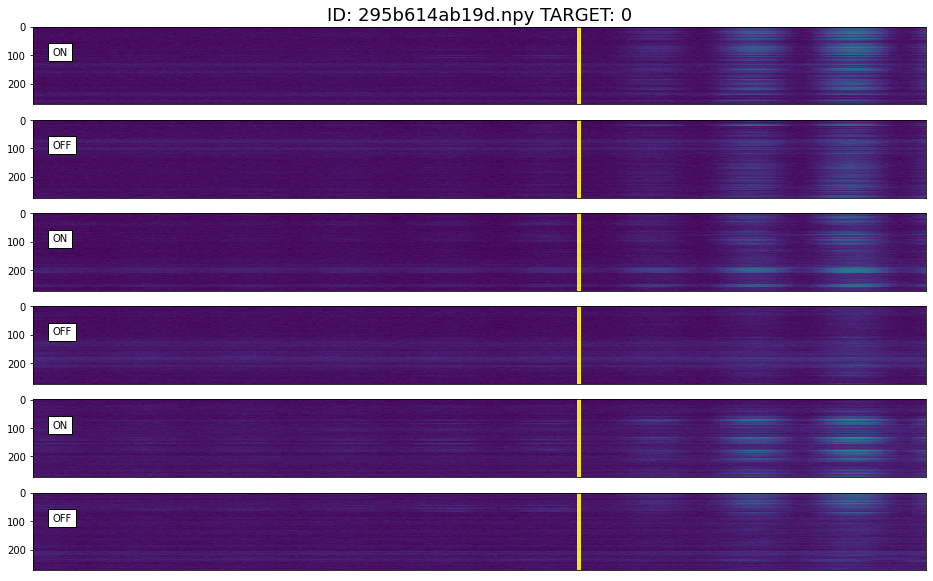

In [12]:
pos_sample = pos_train.sample()
neg_sample = neg_train.sample()

pos_sample_file_path = pos_sample['file_path'].tolist()[0]
pos_sample_label = pos_sample[TARGET].tolist()[0]

neg_sample_file_path = neg_sample['file_path'].tolist()[0]
neg_sample_label = neg_sample[TARGET].tolist()[0]

show_cadence(pos_sample_file_path, label=pos_sample_label)
show_cadence(neg_sample_file_path, label=neg_sample_label)

In [13]:
def show_channels(filename, label=None):
    plt.figure(figsize=(16, 10))
    if label is not None:
        plt.suptitle(f'ID: {os.path.basename(filename)} TARGET: {label}', fontsize=18)
    arr = np.load(filename)
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(arr[i].astype(float))
        plt.grid(b=None)
    plt.show()

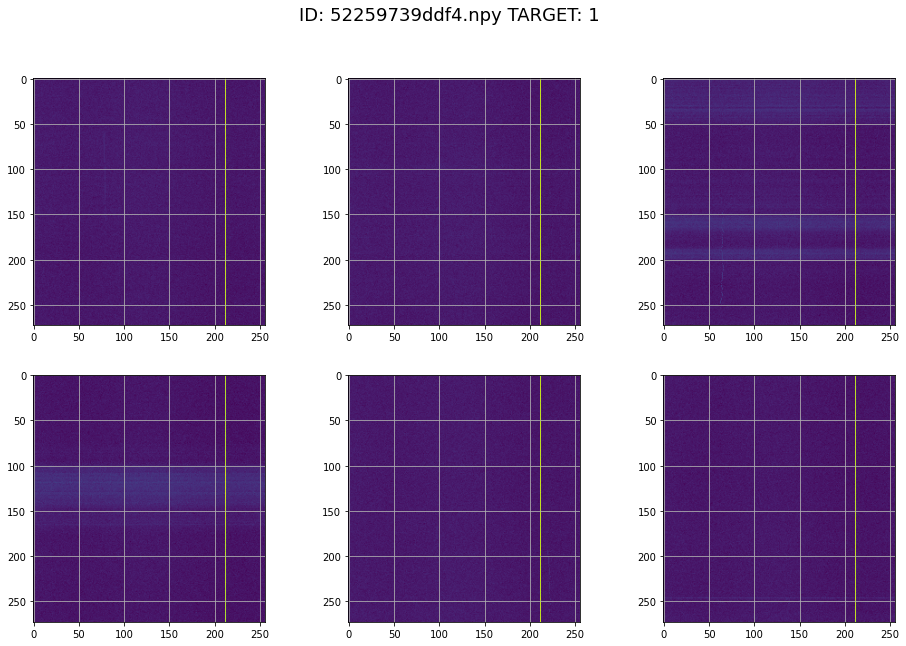

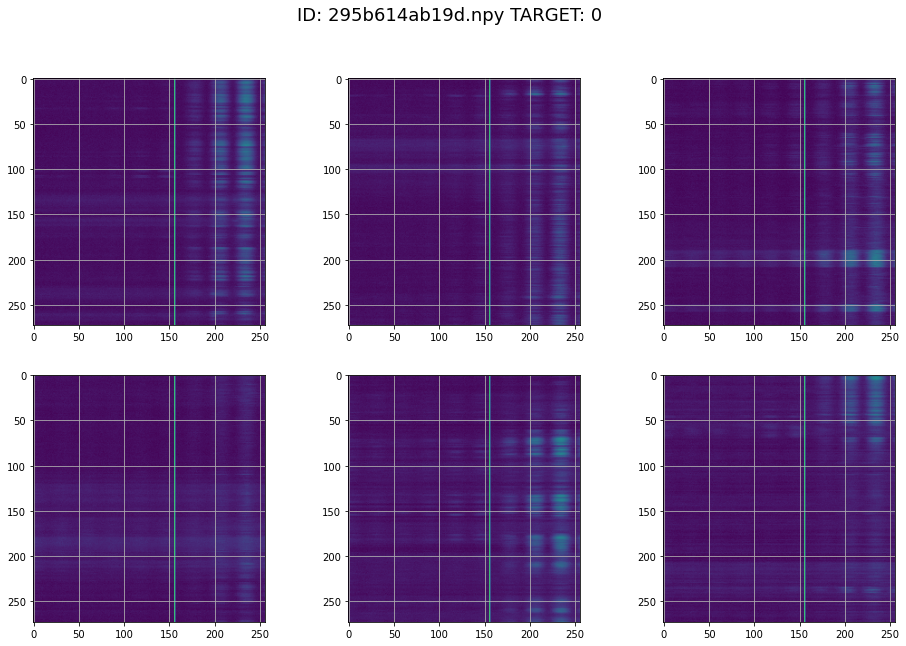

In [14]:
show_channels(pos_sample_file_path, label=pos_sample_label)
show_channels(neg_sample_file_path, label=neg_sample_label)


In [70]:
from sklearn.utils import shuffle
tmp = pos_train.copy()
tmp = tmp.append(train.query('target == 0')[:8000])
tmp = shuffle(tmp)
tmp = tmp.reset_index()
tmp.target.value_counts()

0    8000
1    4694
Name: target, dtype: int64

In [71]:
examples = {}

for i in range(1, 5000):
    examples[i] = {}
    raw = np.load(tmp.loc[i,'file_path'])
    for idx in range(len(raw)):
        examples[i][idx] = np.random.choice(raw[idx].ravel(),5000, replace=False)
        examples[i]['target'] = tmp.loc[i, 'target']

In [72]:
dfs1 = []
dfs2 = []
dfs3 = []
dfs4 = []
dfs5 = []
dfs6 = []

for _, v in tqdm(examples.items()):
    dfs1.append((v[0],v['target']))
    dfs2.append((v[1],v['target']))
    dfs3.append((v[2],v['target']))
    dfs4.append((v[3],v['target']))
    dfs5.append((v[4],v['target']))
    dfs6.append((v[5],v['target']))

100%|██████████| 4999/4999 [00:00<00:00, 403784.65it/s]


In [73]:
def build_dataframe(dfs):
    df = pd.DataFrame(dfs,columns = ['features','target'])
    df = pd.concat([df,pd.DataFrame(df['features'].tolist())],axis=1)
    df.drop('features',axis=1,inplace=True)
    return df

In [74]:
df1 = build_dataframe(dfs1)
df2 = build_dataframe(dfs2)
df3 = build_dataframe(dfs3)
df4 = build_dataframe(dfs4)
df5 = build_dataframe(dfs5)
df6 = build_dataframe(dfs6)

In [75]:
df1.target.value_counts()

0    3091
1    1908
Name: target, dtype: int64

In [82]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

def run_experiments(df):
    X_train, X_test, y_train, y_test = train_test_split(df.drop('target',axis=1), df['target'], test_size=0.2, random_state=1)
    ml = XGBClassifier(max_depth = 12).fit(X_train, y_train)
    pred = ml.predict(X_test)
    return (ml, ml.predict(X_train), pred), confusion_matrix(y_test, pred), classification_report(y_test, pred)

In [83]:
(ml1, y_train1, y_test1), cm1, cr1 = run_experiments(df1)
(ml2, y_train2, y_test2), cm2, cr2 = run_experiments(df2)
(ml3, y_train3, y_test3), cm3, cr3  = run_experiments(df3)
(ml4, y_train4, y_test4), cm4, cr4  = run_experiments(df4)
(ml5, y_train5, y_test5), cm5, cr5  = run_experiments(df5)
(ml6, y_train6, y_test6), cm6, cr6 = run_experiments(df6)

/home/jeris/src/kaggle-competitions/env/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jeris/src/kaggle-competitions/env/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jeris/src/kaggle-competitions/env/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:57:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jeris/src/kaggle-competitions/env/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jeris/src/kaggle-competitions/env/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jeris/src/kaggle-competitions/env/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [84]:
print(cm1, cr1)
print(cm2, cr2)
print(cm3, cr3)
print(cm4, cr4)
print(cm5, cr5)
print(cm6, cr6)


[[541  93]
 [310  56]]               precision    recall  f1-score   support

           0       0.64      0.85      0.73       634
           1       0.38      0.15      0.22       366

    accuracy                           0.60      1000
   macro avg       0.51      0.50      0.47      1000
weighted avg       0.54      0.60      0.54      1000

[[556  78]
 [312  54]]               precision    recall  f1-score   support

           0       0.64      0.88      0.74       634
           1       0.41      0.15      0.22       366

    accuracy                           0.61      1000
   macro avg       0.52      0.51      0.48      1000
weighted avg       0.56      0.61      0.55      1000

[[532 102]
 [315  51]]               precision    recall  f1-score   support

           0       0.63      0.84      0.72       634
           1       0.33      0.14      0.20       366

    accuracy                           0.58      1000
   macro avg       0.48      0.49      0.46      1000
weigh

In [91]:
X_train, X_test, y_train, y_test = train_test_split(df1.drop('target',axis=1), df1['target'], test_size=0.2, random_state=1)
X_stack_train = pd.DataFrame([y_train1,y_train2, y_train3, y_train4, y_train5, y_train6]).T

X_stack_test = pd.DataFrame([y_test1,y_test2, y_test3, y_test4, y_test5, y_test6]).T
# X_stack_test.columns = [0,1,2,3,4,5]

lr = LogisticRegression(class_weight='balanced').fit(X_stack_train, y_train)
pred = lr.predict(X_stack_test)

In [92]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[592  42]
 [345  21]]
              precision    recall  f1-score   support

           0       0.63      0.93      0.75       634
           1       0.33      0.06      0.10       366

    accuracy                           0.61      1000
   macro avg       0.48      0.50      0.43      1000
weighted avg       0.52      0.61      0.51      1000

